In [1]:
import os
import urllib.request
import torch
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from anndata import AnnData
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
from scDGD.classes import GaussianMixture
from scDGD.models import DGD
from scDGD.functions import prepate_data, dgd_train
from scDGD.models import DGD
from scDGD.functions import prepate_data, dgd_train
from scDGD.classes.representation import RepresentationLayer

In [3]:
K562_ad = ad.read('K562.h5ad')
K562_ad.obs['gene'].value_counts()

d:\anaconda\Lib\site-packages\anndata\__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


gene
non-targeting    10691
RPL3              1996
NCBP2              992
KIF11              974
SLC39A9            752
                 ...  
PPP1R10              7
POLR3A               6
POT1                 5
RBM22                5
SEC62                5
Name: count, Length: 2058, dtype: int64

In [4]:
K562_ad = ad.read('K562.h5ad')

#筛选数量超过阈值的perturbation
thresh = 200
value_counts = K562_ad.obs['gene'].value_counts()

filtered_counts = value_counts[value_counts > thresh]
filtered_genes = filtered_counts.index

# 保留通过thresh的gene的行
filtered_data = K562_ad[K562_ad.obs['gene'].isin(filtered_genes)]

# 获取未通过thresh的gene的行
removed_data = K562_ad[~K562_ad.obs['gene'].isin(filtered_genes)]

#筛选出现在转录组里的perturbation

# 提取var表里的gene name列
gene_names_in_var = filtered_data.var['gene_name'].tolist()

# 提取obs表里的gene列
genes_in_obs = filtered_data.obs['gene'].value_counts().index.tolist()

genes_not_in_var = [gene for gene in genes_in_obs if gene not in gene_names_in_var]

genes_not_in_var.remove('non-targeting')

print("perturbation not in transcriptome:", len(genes_not_in_var))

#remove perturbation not in transcriptome
filtered_data = filtered_data[~filtered_data.obs['gene'].isin(genes_not_in_var)]


#filtered_data: perturbation with over 200 samples and in the transcriptome
filtered_data.obs['gene'].value_counts()

d:\anaconda\Lib\site-packages\anndata\__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


perturbation not in transcriptome: 29


gene
non-targeting    10691
RPL3              1996
NCBP2              992
KIF11              974
SLC39A9            752
                 ...  
HUS1               201
NELFCD             201
UBE2L3             201
UROD               201
TRMT112            201
Name: count, Length: 381, dtype: int64

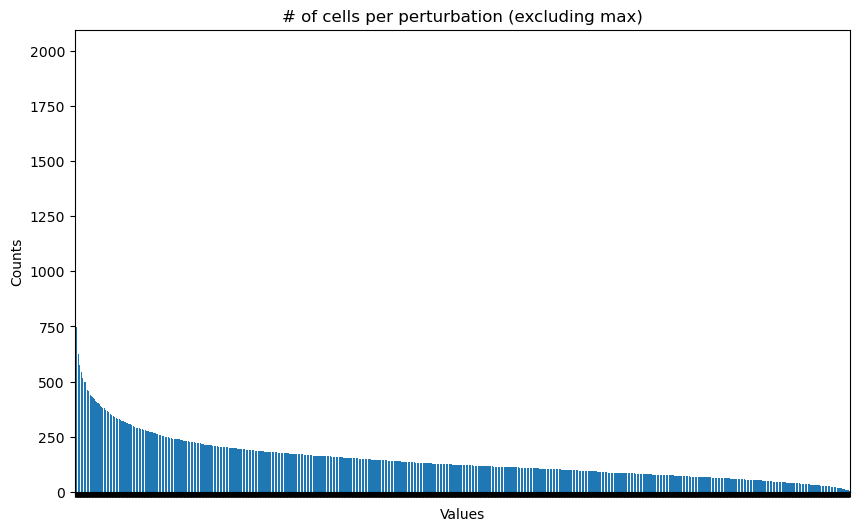

In [5]:
value_counts = K562_ad.obs['gene'].value_counts()
value_counts_excluding_max = value_counts.drop(value_counts.idxmax())

# 制作 count 数量的柱状图
ax = value_counts_excluding_max.plot(kind='bar', figsize=(10, 6), width=0.8)  # 增加柱子的宽度

# 取消 x 坐标标签展示
ax.set_xticklabels([])

# 添加标题和标签
plt.title('# of cells per perturbation (excluding max)')
plt.xlabel('Values')
plt.ylabel('Counts')

# 显示图表
plt.show()

In [6]:
#random sample 100 cell for each perturbation

np.random.seed(42)   # 设置随机种子，以便结果可重复
perturbations = filtered_data.obs['gene'].unique()

index = []

for perturbation in perturbations:
    # 选择当前 perturbation 的所有样本
    perturbation_data = filtered_data[filtered_data.obs['gene'] == perturbation]
    
    # 随机抽取 100 个样本
    sampled_indices = np.random.choice(perturbation_data.obs_names, size=thresh, replace=False)
    index.extend(sampled_indices)

# sampled_data: sampled from filtered_data, 200 samples for each perturbation
sampled_data = filtered_data[index]


In [7]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from scDGD.classes import scDataset

def prepate_data(adata, label_column, train_fraction=0.8, include_test=True, scaling_type='max', batch_size=256, num_w=0):
    '''
    Prepares the pytorch data sets and loaders for training and testing

    For integrating a new data set, set the train_fraction to 1. Otherwise there should always be something left for validation.
    If include_test is True, the split will also include a held-out test set. Otherwise, it will only be train and validation.
    '''

    ###
    # first create a data split
    ###
    labels = adata.obs[label_column]

    train_mode = True
    if 'train_val_test' not in adata.obs.keys():
        if train_fraction < 1.0:
            if include_test:
                train_indices, test_indices = train_test_split(np.arange(len(labels)), test_size=(1.0-train_fraction)/2, stratify=labels)
                train_indices, val_indices = train_test_split(train_indices, test_size=(((1.0-train_fraction)/2)/(1.0-(1.0-train_fraction)/2)), stratify=labels[train_indices])
                # add the split to the anndata object
                train_val_test = [''] * len(labels)
                train_val_test = ['train' if i in train_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['validation' if i in val_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['test' if i in test_indices else train_val_test[i] for i in range(len(labels))]
            else:
                train_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=(1.0-train_fraction), stratify=labels)
                train_val_test = [''] * len(labels)
                train_val_test = ['train' if i in train_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['validation' if i in val_indices else train_val_test[i] for i in range(len(labels))]
        else:
            train_mode = False
            train_val_test = 'test'
        adata.obs['train_val_test'] = train_val_test
    else:
        if len(set(adata.obs['train_val_test'])) == 1:
            train_mode = False
    adata.obs['label'] = labels
    # make sure to afterwards also return the adata object so that the data split can be re-used

    if not include_test:
        adata_train = adata[adata.obs['train_val_test'] == 'train']
        adata_val = adata[adata.obs['train_val_test'] == 'validation']
    else:
        adata_train = adata[adata.obs['train_val_test'] == 'train']
        adata_val = adata[adata.obs['train_val_test'] == 'validation']
        adata_test = adata[adata.obs['train_val_test'] == 'test']

    ###
    # then create the data sets and loaders
    ###

    if train_mode:
        trainset = scDataset(
        adata_train.X,
        adata_train.obs,
        scaling_type=scaling_type,
        label_type='label'
        )
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        validationset = scDataset(
            adata_val.X,
            adata_val.obs,
            scaling_type=scaling_type,
            label_type='label'
        )
        validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        if len(set(adata.obs['train_val_test'])) == 3:
            testset = scDataset(
                adata_test.X,
                adata_test.obs,
                scaling_type=scaling_type,
                label_type='label'
            )
            testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        else:
            testset, testloader = None, None
    else:
        testset = scDataset(
            adata.X,
            adata.obs,
            scaling_type=scaling_type,
            subset=np.where(adata.obs['train_val_test']=='test')[0],
            label_type='label'
        )
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_w)
    
    return adata_train,adata_val, trainloader, validationloader, testloader

In [8]:
def plot_latent_pca_multi(gmm, rep, labels, target_labels=None, n_components=2):
    # 确保GMM模型在CPU上
    gmm = gmm.cpu()
    labels = np.array(labels)
    
    # 筛选目标标签的数据
    if target_labels is not None:
        if not isinstance(target_labels, (list, np.ndarray)):
            raise ValueError("target_labels should be a list or a NumPy array")
        
        if isinstance(target_labels, list):
            target_labels = np.array(target_labels)
        
        indices = np.where(np.isin(labels, target_labels))[0]
        embedding = rep.z[indices].detach().cpu().numpy().copy()  # 获取目标标签的数据
        labels = labels[indices].copy()
    else:
        embedding = rep.z.detach().cpu().numpy().copy()  # 获取所有数据
        labels = labels


    
    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(embedding)
    
    # 创建DataFrame用于绘图
    plot_data = pd.DataFrame(projected, columns=[f"PCA{i+1}" for i in range(n_components)])
    plot_data["label"] = labels
    plot_data["label"] = plot_data["label"].astype("category")

    # 创建一个单一的散点图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_data, x="PCA1", y="PCA2", hue="label", s=50)
    
    # 设置标题和图例
    plt.title("PCA of Target Labels")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # 保存和显示图像

    plt.show()


In [9]:
###
# define desired hyperparameters
###
latent_dim = 50
n_epochs = 300

# define which feature should be observed in clustering (e.g. cell type or disease state)
adata_label_column_name = 'gene'

In [10]:
# prepare the data for training (and testing)
adata_train, adata_val, trainloader, validationloader, testloader = prepate_data(
    sampled_data,
    label_column=adata_label_column_name,
    train_fraction=0.9, 
    include_test=False,
)

C:\Users\xrdpa\AppData\Local\Temp\ipykernel_9132\2467496955.py:38: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['train_val_test'] = train_val_test


In [11]:
latent_dim = 50
nsample = len(trainloader.dataset)

In [12]:
DGD = DGD(out=trainloader.dataset.n_genes, latent=latent_dim)
rep = RepresentationLayer(nrep=latent_dim, nsample=nsample,values=torch.zeros(size=(nsample,latent_dim)))
gmm = GaussianMixture(Nmix=1, dim=latent_dim)
DGD.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_decoder.pt'))
rep.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_representation.pt'))
gmm.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_gmm.pt'))

<All keys matched successfully>

In [13]:
labels = adata_train.obs["gene"].values

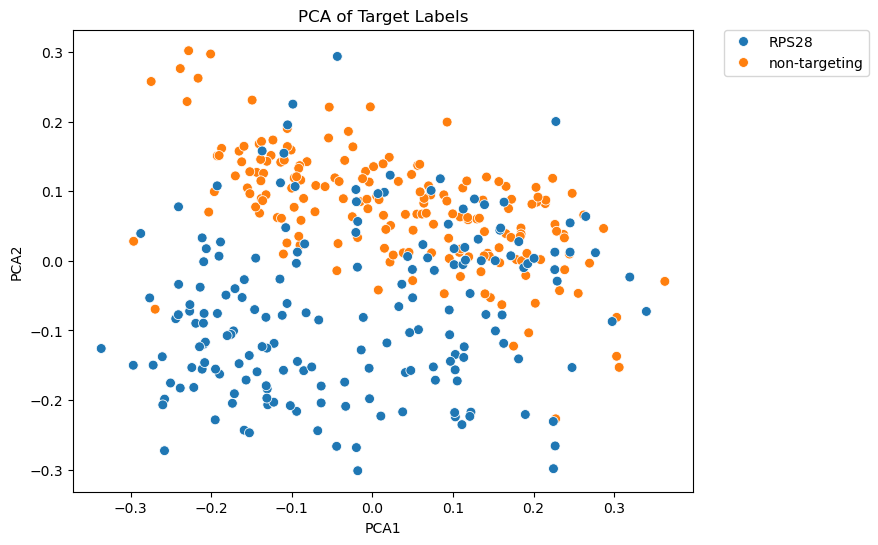

In [14]:
perturb_list = ['RPS28','non-targeting']
plot_latent_pca_multi(gmm, rep, labels, target_labels=perturb_list)

In [15]:
def plot(gmm, rep, labels, target_labels=None, n_components=2):
    # 确保GMM模型在CPU上
    gmm = gmm.cpu()
    labels = np.array(labels)
    
    # 筛选目标标签的数据
    if target_labels is not None:
        if not isinstance(target_labels, (list, np.ndarray)):
            raise ValueError("target_labels should be a list or a NumPy array")
        
        if isinstance(target_labels, list):
            target_labels = np.array(target_labels)
        
        indices = np.where(np.isin(labels, target_labels))[0]
        embedding = rep.z[indices].detach().cpu().numpy().copy()  # 获取目标标签的数据
        labels = labels[indices].copy()
    else:
        embedding = rep.z.detach().cpu().numpy().copy()  # 获取所有数据
        labels = labels


    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(embedding)
    
    # 创建DataFrame用于绘图
    plot_data = pd.DataFrame(projected, columns=[f"PCA{i+1}" for i in range(n_components)])
    plot_data["label"] = labels
    plot_data["label"] = plot_data["label"].astype("category")

    # 创建一个单一的散点图
    #plt.figure(figsize=(8, 6))
    #sns.scatterplot(data=plot_data, x="PCA1", y="PCA2", hue="label", s=50)
    
    # 设置标题和图例
    #plt.title("PCA of Target Labels")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # 保存和显示图像

    #plt.show()
    return pca, plot_data, projected


In [16]:
def plot_new_point(pca, pca_data, projected, rep_new, round=None, epochs=None):
    projected_new = pca.transform(rep_new.z.cpu().detach().clone().numpy())
    pca_data_new = pd.DataFrame(data=projected_new, columns=['PCA1','PCA2'])
    pca_data_new['label'] = 'new control data' 
    # Combine the original PCA data with the new PCA data
    combined_data = pd.concat([pca_data, pca_data_new], ignore_index=True)

    # Determine the unique labels that actually appear in the combined data
    actual_labels = combined_data['label'].unique()

    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    
    # Scatter plot with color differentiation based on the label
    #sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=combined_data, s=25, hue_order=actual_labels)
    sns.scatterplot(
        x='PCA1', y='PCA2', hue='label', data=combined_data, 
        s=25, hue_order=actual_labels
    )
    
    
    # Customize the legend
    ax.legend(loc=2, bbox_to_anchor=(1.05, 1.0), borderaxespad=0., fontsize='8')

    if round is not None:
        ax.set_title(f'Round: {round}')
        
    # Create the file name for saving directly in the current directory
    plt.savefig(f"Locate_new_data_epoch_{epochs}.pdf", format='pdf', bbox_inches='tight')

    plt.show()

In [17]:
def plot_arrow(pca, pca_data, projected, rep_raw, rep_new, epochs=None, round=None):
    # Transform the raw and new data using PCA
    projected_raw = pca.transform(rep_raw.cpu().detach().numpy())
    projected_new = pca.transform(rep_new.cpu().detach().numpy())

    # Create DataFrames for the raw and new data with appropriate labels
    pca_data_raw = pd.DataFrame(data=projected_raw, columns=['PCA1','PCA2'])
    pca_data_new = pd.DataFrame(data=projected_new, columns=['PCA1','PCA2'])
    pca_data_raw['label'] = 'raw control data'
    pca_data_new['label'] = 'updated control data'

    #base_data = pd.concat([pca_data, pca_data_new, pca_data_raw], ignore_index=True)
    exp_data = pd.concat([pca_data_raw, pca_data_new], ignore_index=True)

    # Determine the unique labels that actually appear in the combined data
    actual_labels = plot_data['label'].unique()

    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    # Scatter plot with color differentiation based on the label
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=plot_data, s=25, hue_order=actual_labels, alpha = 0.2)
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=exp_data, s=10)

    # Add arrows from the raw control data to the updated control data
    for i in range(len(projected_raw)):
        ax.arrow(projected_raw[i, 0], projected_raw[i, 1],
                    projected_new[i, 0] - projected_raw[i, 0],
                    projected_new[i, 1] - projected_raw[i, 1],
                    head_width=0.01, head_length=0.01, fc='blue', ec='blue', alpha=0.3)

    # Customize the legend
    ax.legend(loc=2, bbox_to_anchor=(1.05, 1.0), borderaxespad=0., fontsize='8')
    if epochs is not None:
        ax.set_title(f'Epoch: {epochs}')

    # Save the figure as a PDF with the epoch number in the file name
    plt.savefig(f"MED12_round_epoch_{epochs}.pdf", format='pdf', bbox_inches='tight')

    plt.show()

### perturbation experiment

In [18]:
import warnings

# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
def decode_rep(representation, lib, model, control_samp_adata):
    '''
    Decodes a representation to a count matrix using the given model
    '''
    # Set the model to evaluation mode
    model.eval()

    perdiction = model(representation.z.detach())* lib

    obs = control_samp_adata.obs.copy()
    var = control_samp_adata.var.copy()
    # Create a new AnnData object with the predicted counts
    adata_pred = ad.AnnData(X=perdiction.detach().cpu().numpy(), obs=obs, var=var)
    adata_pred.obs["gene"] = 'prediction'

    # Concatenate the new AnnData object with the original one
    new_adata = control_samp_adata.concatenate(adata_pred, join='inner') 
    
    return new_adata

def get_true_adata(perturb_list, adata_train):
    true_adata = adata_train[adata_train.obs['gene'].isin(perturb_list)]

    return true_adata

def DEG_analysis(adata):
    #
    temp_adata = adata.copy()
    sc.pp.normalize_total(temp_adata, target_sum=None)
    sc.pp.log1p(temp_adata)
    sc.tl.rank_genes_groups(temp_adata, groupby = 'gene',method='wilcoxon', rankby_abs=True)

    return temp_adata

def true_perturb_get_top(adata, group_name='non-targeting', n_DEG=None):
    # 获取差异表达的结果
    result = adata.uns['rank_genes_groups']

    gene_names = result['names']
    logfoldchanges = result['logfoldchanges']
    pvals = result['pvals']
    score = result['scores']
    
    # 获取指定组下的基因、logFC、p-values 和 score
    genes_in_group = gene_names[group_name]
    logfc_in_group = logfoldchanges[group_name]
    pvals_in_group = pvals[group_name]
    score_in_group = score[group_name]

    # 创建一个 DataFrame 来存储结果，直接使用原始顺序
    df_group = pd.DataFrame({
        'Gene': genes_in_group,
        'LogFC': logfc_in_group,
        'PValue': pvals_in_group,
        'Score': score_in_group
    })

    # 选择前 n_DEG 个基因，保留原始顺序
    if n_DEG is not None:
        top_degs = df_group.iloc[:n_DEG]
        genes_in_group = genes_in_group[:n_DEG]
    else:
        top_degs = df_group

    return top_degs, genes_in_group

def same_direction(true_deg, new_deg, true_genes_list):
    # get true degs in new degs
    filtered_new_deg = new_deg[new_deg['Gene'].isin(true_genes_list)]
    # sort by gene
    sorted_true_deg = true_deg.sort_values(by='Gene').reset_index(drop=True)
    sorted_filtered_deg = filtered_new_deg.sort_values(by='Gene').reset_index(drop=True)
    # get the same direction
    df1_sign = np.sign(sorted_true_deg['Score'])
    df2_sign = np.sign(sorted_filtered_deg['Score'])

    # 比较两个 df 的 Score 列符号是否相同
    same_sign_count = (df1_sign == df2_sign).sum()

    # 输出符号相同的行数

    return same_sign_count

def get_num_same_direction(true_adata, new_adata):

    # analyze the DEGs
    temp_new_adata = DEG_analysis(new_adata)
    temp_true_adata = DEG_analysis(true_adata)
    # get the top DEGs
    true_top_degs, true_genes_list = true_perturb_get_top(temp_true_adata, group_name='non-targeting', n_DEG=200)
    new_top_degs,_ = true_perturb_get_top(temp_new_adata, group_name='non-targeting')   

    # num of same direction
    same_deg = same_direction(true_top_degs, new_top_degs, true_genes_list)

    return same_deg


In [21]:
def get_logfc(adata, group_name='non-targeting'):
    # 获取差异表达的结果
    result = adata.uns['rank_genes_groups']

    gene_names = result['names']
    logfoldchanges = result['logfoldchanges']
    
    # 获取指定组下的基因、logFC、p-values 和 score
    genes_in_group = gene_names[group_name]
    logfc_in_group = logfoldchanges[group_name]

    # 创建一个 DataFrame 来存储结果，直接使用原始顺序
    df_group = pd.DataFrame({
        'Gene': genes_in_group,
        'LogFC': logfc_in_group,
    })

    return df_group

from scipy.stats import pearsonr
def logfc_pearson_correlation(all_genes_true, all_genes_new):
    """
    输入两组 all_genes 数据，排序并对齐基因名，计算 LogFC + 1 的 Pearson 相关系数。
    
    参数:
    - all_genes_1: 第一组基因表达数据 (DataFrame)，包含 Gene 和 LogFC 列。
    - all_genes_2: 第二组基因表达数据 (DataFrame)，包含 Gene 和 LogFC 列。

    返回:
    - pearson_corr: LogFC + 1 的 Pearson 相关系数
    """
    # 确保 Gene 列存在于两组数据中
    if 'Gene' not in all_genes_true.columns or 'Gene' not in all_genes_new.columns:
        raise ValueError("Both input DataFrames must contain a 'Gene' column.")
    
    # 对 Gene 进行排序并按 Gene 列进行合并，保证基因对齐
    merged_data = pd.merge(all_genes_true[['Gene', 'LogFC']], all_genes_new[['Gene', 'LogFC']],
                           on='Gene', suffixes=('_true', '_new'))
    
    # 计算 LogFC + 1
    logfc_1 = merged_data['LogFC_true']
    logfc_2 = merged_data['LogFC_new']
    
    # 计算 Pearson 相关系数
    pearson_corr, _ = pearsonr(logfc_1, logfc_2)
    
    return pearson_corr

def get_pearson_cor(true_adata, new_adata):
    # analyze the DEGs
    temp_new_adata = DEG_analysis(new_adata)
    temp_true_adata = DEG_analysis(true_adata)
    # get DEGs
    true_logfc = get_logfc(temp_true_adata)
    new_logfc = get_logfc(temp_new_adata)
    # get pearson correlation
    pearson_corr = logfc_pearson_correlation(true_logfc, new_logfc)

    return pearson_corr

In [22]:

def get_best_logfc(adata, group_name='non-targeting', n_DEG=None):
    # 获取差异表达的结果
    result = adata.uns['rank_genes_groups']

    gene_names = result['names']
    logfoldchanges = result['logfoldchanges']
    score = result['scores']
    
    # 获取指定组下的基因、logFC、p-values 和 score
    genes_in_group = gene_names[group_name]
    logfc_in_group = logfoldchanges[group_name]
    score_in_group = score[group_name]

    # 创建一个 DataFrame 来存储结果，直接使用原始顺序
    df_group = pd.DataFrame({
        'Gene': genes_in_group,
        'LogFC': logfc_in_group,
        'Score': score_in_group
    })

    # 选择前 n_DEG 个基因，保留原始顺序
    top_degs = df_group.iloc[:n_DEG]
    genes_in_group = genes_in_group[:n_DEG]

    return top_degs, genes_in_group

def logfc_prc_best(true_deg, new_deg, true_genes_list):
    # get true degs in new degs
    filtered_new_deg = new_deg[new_deg['Gene'].isin(true_genes_list)]
    #print("new_deg",filtered_new_deg)
    #print("true_deg",true_deg)
    # sort by gene
    merged_data = pd.merge(true_deg[['Gene', 'LogFC']], filtered_new_deg[['Gene', 'LogFC']],
                           on='Gene', suffixes=('_true', '_new'))

    # 计算 LogFC + 1
    logfc_1 = merged_data['LogFC_true'] + 1
    logfc_2 = merged_data['LogFC_new'] + 1
    
    # 计算 Pearson 相关系数
    pearson_corr, _ = pearsonr(logfc_1, logfc_2)
    
    return pearson_corr

def get_pearson_cor_top_gene(true_adata, new_adata, num_DEG=200):
    # analyze the DEGs
    temp_new_adata = DEG_analysis(new_adata)
    temp_true_adata = DEG_analysis(true_adata)
    # get DEGs
    true_logfc, gene_list = get_best_logfc(temp_true_adata, n_DEG=num_DEG)
    new_logfc = get_logfc(temp_new_adata)
    # get pearson correlation
    pearson_corr = logfc_prc_best(true_logfc, new_logfc, gene_list)

    return pearson_corr


In [23]:
#prepare control data for perturbation, 50 samples for each perturbation
control_all_data = filtered_data[filtered_data.obs['gene'] == 'non-targeting']
control_all_data = control_all_data[~control_all_data.obs_names.isin(index)].copy()
contr_sampled_indices = np.random.choice(control_all_data.obs_names, size=200, replace=False)
contro_samp_data = control_all_data[contr_sampled_indices]


In [29]:
def locate_new_control(contro_samp_data, DGD, gene=None):
    #1. learn representations for the new control samples

    #1.1 new dataset and loader
    control_dataset = scDataset(
            contro_samp_data.X,
            contro_samp_data.obs,
            scaling_type='max',
            label_type='label'
            )
    control_loader = torch.utils.data.DataLoader(control_dataset, batch_size=16, shuffle=False, num_workers=0)

    lib_list = []
    for x,lib,i in control_loader:
        lib_list.append(lib)
    lib_list = torch.cat(lib_list, dim=0)


    #1.2 representation layer and optimizer
    control_rep = RepresentationLayer(nrep=latent_dim,nsample=len(control_loader.dataset),values=torch.zeros(size=(len(control_loader.dataset),latent_dim)))
    control_rep_optimizer = torch.optim.Adam(control_rep.parameters(), lr=1e-3, weight_decay=1e-4, betas=[0.5,0.7])
    

    #pert_list = [gene,'non-targeting']
    #pca, plot_data, projected = plot(gmm, rep, labels, pert_list, n_components=2)

    control_nsample = len(control_loader.dataset)

    n_epochs = 300
    DGD.eval()
    new_control_avg = []

    for param in DGD.parameters():
        param.requires_grad = False

    for epoch in range(n_epochs):
        control_rep_optimizer.zero_grad()
        new_control_avg.append(0)
        for x,lib,i in control_loader:
            # x has shape (n,d)
            # z is chosen with i by intermediately viewing it as (n,m,c,l) and then shaping it to (n*m*c,l)
            z = control_rep(i)
            y = DGD(z)
            # for calculating the loss correctly, x lib and y have to be brought to 4 dimensions
            ## x and y are viewed as (n,m,c,d) and lib is extended to (n,1,1,1)
            recon_loss_x = DGD.nb.loss(x, lib, y).sum()
            gmm_error = - gmm(z).sum()
            #print("recon_loss_x:",recon_loss_x,"gmm_error:",gmm_error)
            loss = recon_loss_x.clone() + gmm_error.clone()
            #print(loss)
            loss.backward()

            new_control_avg[-1] += loss.item()/(control_nsample*control_loader.dataset.n_genes*len(control_loader.dataset))

        control_rep_optimizer.step()
        #if epoch == 0 or epoch == n_epochs-1:
        #if epoch == n_epochs-1:
        #    print('Epoch:',epoch,'  Loss:', new_control_avg[-1])
        #    plot_new_point(pca,plot_data,projected,control_rep,epochs=epoch)

        
    #return control_rep, control_rep_optimizer, lib_list, pca, plot_data, projected
    return control_rep, control_rep_optimizer, lib_list
    

In [30]:
def insilico_perturb(gene_name, control_rep, control_rep_opt, lib_list, DGD, contro_samp_data, pca, plot_data, projected, degs=True, prc=True):

    perturb_list = [gene_name,'non-targeting']

    true_adata = get_true_adata(perturb_list, adata_train)
    # 2. predict the counts of the new representations and save reps and predictions for reference to time point zero
    #rep_new_control: representation of the new control data, saved for PCA
    raw_rep = control_rep.z.detach().cpu().clone()
    from scDGD.classes.output_distributions import logNBdensity

    # 3. create perturbed samples by setting desired gene count to 0

    #check if the gene is in the transcriptome and get the index
    transcri_gene = contro_samp_data.var['gene_name'].tolist()
    if gene_name not in transcri_gene:
        print(f"Error: Gene {gene_name} is not in the transcriptome. Terminating the function.")
        return None  # 基因不在转录组中，终止函数并返回 None

    # 如果基因存在，继续执行
    perturb_gene_index = transcri_gene.index(gene_name)
    print("Gene:", gene_name, "is in the transcriptome, index:", perturb_gene_index)
    
    #update the sample by setting the gene count to 0
    updated_sample = ((DGD(control_rep()).detach()) * lib_list).cpu().numpy().astype(np.float32)
    updated_sample[:, perturb_gene_index] = 0
    updated_sample = torch.tensor(updated_sample)

    # create a dataset and loader for the perturbed samples
    pert_dataset = scDataset(
            updated_sample,
            contro_samp_data.obs,
            scaling_type='max',
            label_type='label'
            )
    pert_loader = torch.utils.data.DataLoader(pert_dataset, batch_size=16, shuffle=False, num_workers=0)

    #lib_list = []
    #for x,lib,i in pert_loader:
    #    lib_list.append(lib)
    #lib_list = torch.cat(lib_list, dim=0)

    epochs = 100
    DGD.eval()
    pert_avg = []

    prc_list = []
    same_direction_list = []
    for epoch in range(epochs):
        # perturb the new control data
        control_rep_opt.zero_grad()
        pert_avg.append(0)
        for x,lib,i in pert_loader:

            z = control_rep(i)
            y = DGD(z)

            recon_loss_x = -logNBdensity(x[:, perturb_gene_index], DGD.nb.rescale(lib, y)[:, perturb_gene_index], (torch.exp(DGD.nb.log_r)+1)[0,perturb_gene_index]).sum()
            #gmm_error = - gmm(z).sum()
            #print("recon_loss_x:",recon_loss_x)
            loss1 = recon_loss_x.clone()
            #print(loss)
            loss1.backward()

            pert_avg[-1] += loss1.item()/(nsample*pert_loader.dataset.n_genes*len(pert_loader.dataset))
        
        # update the representation
        control_rep_opt.step()

        # print the loss
        #if epoch  == 0 or epoch==epochs-1 or epoch == 50:
        #    print('Epoch:',epoch)
        #    curret_rep = control_rep.z.detach().cpu().clone()
        #    plot_arrow(pca, plot_data, projected, raw_rep, curret_rep, epochs=epoch, round=round)
        
        # same direction
        if degs:
            new_adata = decode_rep(control_rep, lib_list, DGD, contro_samp_data)
            same_deg = get_num_same_direction(true_adata, new_adata)
            same_direction_list.append(same_deg)

        if prc and (epoch % 10 == 0 or epoch == epochs - 1):
            new_adata = decode_rep(control_rep, lib_list, DGD, contro_samp_data)

            # all gene
            #prc = get_pearson_cor(true_adata, new_adata)
            # only top gene
            prc = get_pearson_cor_top_gene(true_adata, new_adata)
            #print("Pearson correlation at epoch:", epoch, ":", prc)
    
            prc_list.append(prc)
            
            if epoch == epochs-1:
                print(gene_name,"final Pearson correlation:", prc, "prc increase:", f"{((prc - prc_list[0])/ np.abs(prc_list[0])) * 100:.2f}%")
        #if epoch%20 == 0 or epoch == epochs-1:
        #    print("same direction at epoch:", epoch, ":", same_deg)

    return control_rep, same_direction_list, prc_list

In [199]:
# case study: RPS28

case_name = ['HNRNPC']

control_rep, control_rep_optimizer, lib_list = locate_new_control(contro_samp_data, DGD)
deg_mode = False
prc_mode = True
for gene in case_name:
    control_rep_copy = RepresentationLayer(nrep=latent_dim,nsample=200,values=control_rep.z.detach().clone())
    control_rep_optimizer_copy = torch.optim.Adam(control_rep_copy.parameters(), lr=1e-3, weight_decay=1e-4, betas=[0.5,0.7])

    test_gene = gene
    pert_list = [test_gene,'non-targeting']
    pca, plot_data, projected = plot(gmm, rep, labels, pert_list, n_components=2)
    control_rep, _,_ = insilico_perturb(test_gene, control_rep, control_rep_optimizer, lib_list, DGD, contro_samp_data, pca, plot_data, projected, degs = deg_mode, prc = prc_mode)

Gene: HNRNPC is in the transcriptome, index: 5570
HNRNPC final Pearson correlation: 0.7302415594495064 prc increase: 162.12%


In [178]:
gene_name = []
results = []
with open('perturb_and_result_list.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # 解析每一行，提取基因名和结果
        gene_part, result_part = line.split(', Result: ')
        gene = gene_part.split(': ')[1]  # 获取基因名
        result_str = result_part.strip()  # 去掉空白字符

        # 处理结果，将字符串转换为列表
        result = eval(result_str)  # 使用 eval 将字符串转换为列表

        # 将数据添加到对应的列表
        gene_name.append(gene)
        results.append(result)

In [188]:
# 使用切片方法找到最后一列的最大三个值的行索引
last_column_values = [row[-1] for row in results]  # 获取最后一列的所有值
sorted_indices = sorted(range(len(last_column_values)), key=lambda i: last_column_values[i], reverse=True)  # 获取索引并按值降序排序

# 获取最大三个值的索引
top_3_indices = sorted_indices[:10]

print(f"最后一列最大三个值的行索引: {top_3_indices}")

最后一列最大三个值的行索引: [133, 98, 321, 76, 194, 73, 220, 316, 127, 244]


In [192]:
for index in top_3_indices:
    print(gene_name[index])

RPS28
RPS3
RPS9
RPS24
HNRNPC
CSE1L
RUVBL1
RPL10
RPS11
RPS15A


['ENSG00000099901' 'ENSG00000181163' 'ENSG00000167088' 'ENSG00000068028'
 'ENSG00000172270' 'ENSG00000260260' 'ENSG00000124207' 'ENSG00000245532'
 'ENSG00000004779' 'ENSG00000144381' 'ENSG00000203618' 'ENSG00000198830'
 'ENSG00000117632' 'ENSG00000167996' 'ENSG00000080824' 'ENSG00000132341'
 'ENSG00000272602' 'ENSG00000163931' 'ENSG00000267100' 'ENSG00000226950']


C:\Users\xrdpa\AppData\Local\Temp\ipykernel_9132\2440771292.py:25: RuntimeWarning: divide by zero encountered in log
  RPS28_true_log = np.log(RPS28_true.X / control_train_means)


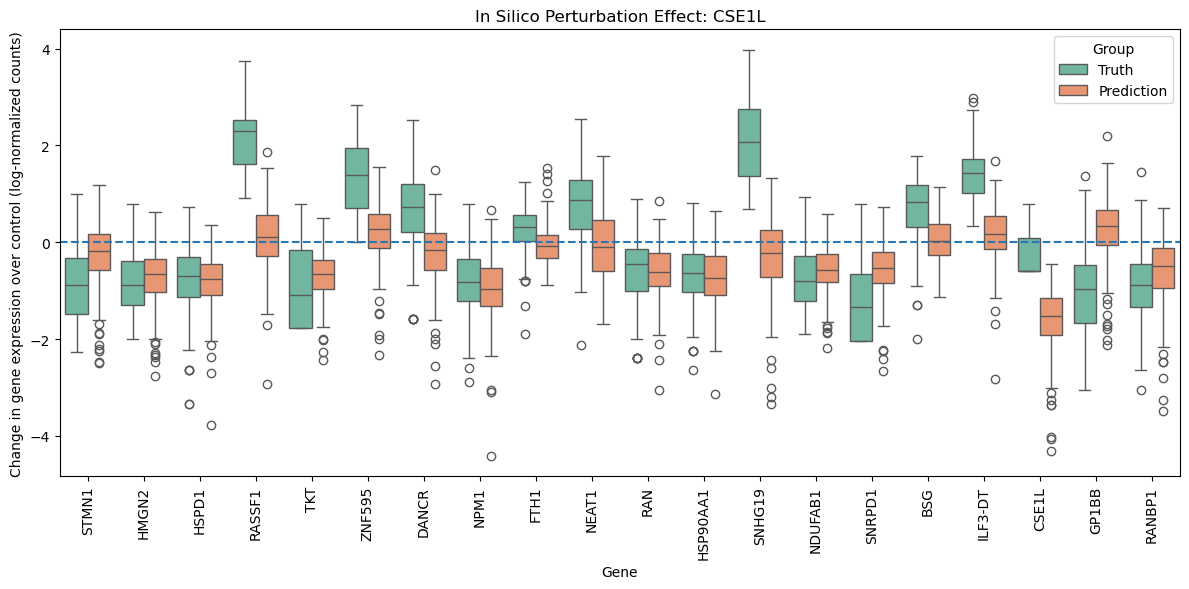

In [197]:
base = get_true_adata(['CSE1L', 'non-targeting'], adata_train)
base = DEG_analysis(base)
top_genes = base.uns['rank_genes_groups']['names']['non-targeting'][:20]
print(top_genes)

controll_train = get_true_adata(['non-targeting'], adata_train)
controll_train = controll_train[:, controll_train.var_names.isin(top_genes)].copy()
control_test = contro_samp_data.copy()
control_test = control_test[:, control_test.var_names.isin(top_genes)].copy()
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['CSE1L'], adata_train)

RPS28_new = RPS28_new[:, RPS28_new.var_names.isin(top_genes)].copy()
RPS28_true = RPS28_true[:, RPS28_true.var_names.isin(top_genes)].copy()

control_train_means = np.mean(controll_train.X, axis=0)
control_test_means = np.mean(control_test.X, axis=0)
assert len(control_train_means) == RPS28_true.shape[1], "基因数量不匹配"

RPS28_true_log = np.log(RPS28_true.X / control_train_means)

assert len(control_test_means) == RPS28_new.shape[1], "基因数量不匹配"

RPS28_new_log = np.log(RPS28_new.X / control_test_means)
DEG_names = RPS28_true.var['gene_name']
# 将每组数据转换为 pandas DataFrame 以便于绘图
true_df = pd.DataFrame(RPS28_true_log, columns=DEG_names)
new_df = pd.DataFrame(RPS28_new_log, columns=DEG_names)

# 添加额外的一列用于区分两组数据
true_df['Group'] = 'Truth'
new_df['Group'] = 'Prediction'

# 将两组数据合并在一起，用于绘制箱线图
combined_df = pd.concat([true_df, new_df])

# 将数据从宽格式转换为长格式，便于绘图
melted_df = pd.melt(combined_df, id_vars='Group', var_name='Gene', value_name='Expression')

# 创建箱线图，使用 seaborn 的 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='Expression', hue='Group', data=melted_df, palette='Set2')

# 调整图表的旋转角度以便于查看基因标签
plt.xticks(rotation=90)
plt.axhline(0, color='#2878B5', linestyle='--')
# 添加标题和轴标签
plt.title('In Silico Perturbation Effect: CSE1L')

plt.ylabel('Change in gene expression over control (log-normalized counts)')

# 显示图表
plt.tight_layout()
plt.savefig('CSE1L_effect.pdf')
plt.show()

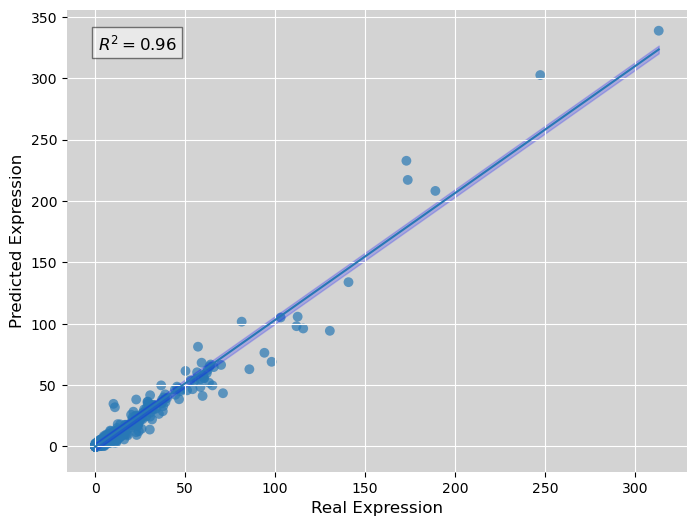

In [198]:
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['CSE1L'], adata_train)
mean_true = np.mean(RPS28_true.X, axis=0)
mean_new = np.mean(RPS28_new.X, axis=0)

corr, p_value = pearsonr(mean_true, mean_new)
r_squared = corr ** 2  # 计算 R^2

# 线性回归拟合
slope, intercept = np.polyfit(mean_true, mean_new, 1)

# 使用 mean_true 的最小值和最大值来创建 x 值范围
x_vals = np.linspace(mean_true.min(), mean_true.max(), 100)
y_vals = slope * x_vals + intercept

# 计算回归线的标准误差，展示置信区间（波动范围）
y_fit = slope * mean_true + intercept
residuals = mean_new - y_fit
std_err = np.std(residuals)
confidence_interval = 1.96 * std_err

# 绘制散点图和置信区间
plt.figure(figsize=(8, 6))
plt.scatter(mean_true, mean_new, alpha=0.7, color='#2878B5', edgecolors='none', s=50)  # 取消黑边

# 绘制回归直线，颜色与散点一致
plt.plot(x_vals, y_vals, color='#2878B5')

# 绘制置信区间（波动范围）
plt.fill_between(x_vals, y_vals - confidence_interval, y_vals + confidence_interval, 
                 color='b', alpha=0.2, label='95% Confidence Interval')

# 添加标题和标签
plt.xlabel('Real Expression', fontsize=12)
plt.ylabel('Predicted Expression', fontsize=12)

# 设置背景颜色为淡灰色，网格线为白色
plt.gca().set_facecolor('#d3d3d3')  # 背景淡灰色
plt.grid(True, color='white')  # 网格线白色

# 取消坐标框的黑边
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 取消上边框
ax.spines['right'].set_visible(False)  # 取消右边框
ax.spines['left'].set_visible(False)   # 取消左边框
ax.spines['bottom'].set_visible(False)  # 取消下边框

# 在图片中显示 R^2
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 显示图形
plt.savefig("CSE1L_mean_expression.pdf", format='pdf', bbox_inches='tight')
plt.show()

['ENSG00000092199' 'ENSG00000175061' 'ENSG00000163468' 'ENSG00000245910'
 'ENSG00000103342' 'ENSG00000198824' 'ENSG00000234741' 'ENSG00000142864'
 'ENSG00000125835' 'ENSG00000152234' 'ENSG00000198840' 'ENSG00000163931'
 'ENSG00000163655' 'ENSG00000269893' 'ENSG00000198727' 'ENSG00000206573'
 'ENSG00000170606' 'ENSG00000011260' 'ENSG00000082515' 'ENSG00000255717']


C:\Users\xrdpa\AppData\Local\Temp\ipykernel_9132\2590945413.py:25: RuntimeWarning: divide by zero encountered in log
  RPS28_true_log = np.log(RPS28_true.X / control_train_means)


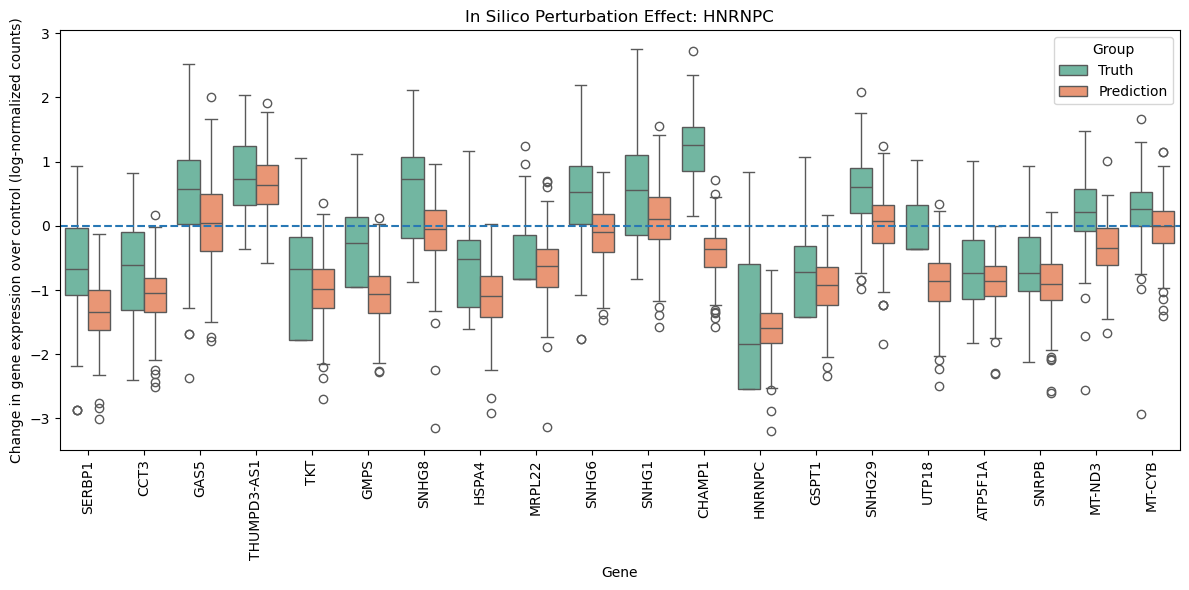

In [195]:
base = get_true_adata(['HNRNPC', 'non-targeting'], adata_train)
base = DEG_analysis(base)
top_genes = base.uns['rank_genes_groups']['names']['non-targeting'][:20]
print(top_genes)

controll_train = get_true_adata(['non-targeting'], adata_train)
controll_train = controll_train[:, controll_train.var_names.isin(top_genes)].copy()
control_test = contro_samp_data.copy()
control_test = control_test[:, control_test.var_names.isin(top_genes)].copy()
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['HNRNPC'], adata_train)

RPS28_new = RPS28_new[:, RPS28_new.var_names.isin(top_genes)].copy()
RPS28_true = RPS28_true[:, RPS28_true.var_names.isin(top_genes)].copy()

control_train_means = np.mean(controll_train.X, axis=0)
control_test_means = np.mean(control_test.X, axis=0)
assert len(control_train_means) == RPS28_true.shape[1], "基因数量不匹配"

RPS28_true_log = np.log(RPS28_true.X / control_train_means)

assert len(control_test_means) == RPS28_new.shape[1], "基因数量不匹配"

RPS28_new_log = np.log(RPS28_new.X / control_test_means)
DEG_names = RPS28_true.var['gene_name']
# 将每组数据转换为 pandas DataFrame 以便于绘图
true_df = pd.DataFrame(RPS28_true_log, columns=DEG_names)
new_df = pd.DataFrame(RPS28_new_log, columns=DEG_names)

# 添加额外的一列用于区分两组数据
true_df['Group'] = 'Truth'
new_df['Group'] = 'Prediction'

# 将两组数据合并在一起，用于绘制箱线图
combined_df = pd.concat([true_df, new_df])

# 将数据从宽格式转换为长格式，便于绘图
melted_df = pd.melt(combined_df, id_vars='Group', var_name='Gene', value_name='Expression')

# 创建箱线图，使用 seaborn 的 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='Expression', hue='Group', data=melted_df, palette='Set2')

# 调整图表的旋转角度以便于查看基因标签
plt.xticks(rotation=90)
plt.axhline(0, color='#2878B5', linestyle='--')
# 添加标题和轴标签
plt.title('In Silico Perturbation Effect: HNRNPC')

plt.ylabel('Change in gene expression over control (log-normalized counts)')

# 显示图表
plt.tight_layout()
plt.savefig('HNRNPC_effect.pdf')
plt.show()

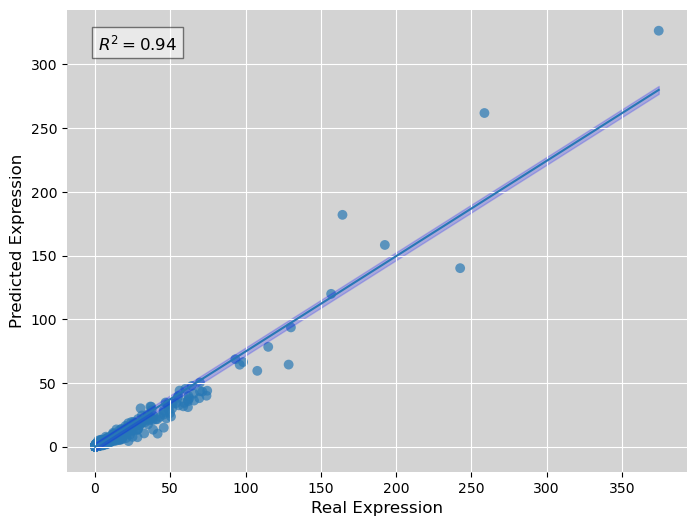

In [200]:
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['HNRNPC'], adata_train)
mean_true = np.mean(RPS28_true.X, axis=0)
mean_new = np.mean(RPS28_new.X, axis=0)

corr, p_value = pearsonr(mean_true, mean_new)
r_squared = corr ** 2  # 计算 R^2

# 线性回归拟合
slope, intercept = np.polyfit(mean_true, mean_new, 1)

# 使用 mean_true 的最小值和最大值来创建 x 值范围
x_vals = np.linspace(mean_true.min(), mean_true.max(), 100)
y_vals = slope * x_vals + intercept

# 计算回归线的标准误差，展示置信区间（波动范围）
y_fit = slope * mean_true + intercept
residuals = mean_new - y_fit
std_err = np.std(residuals)
confidence_interval = 1.96 * std_err

# 绘制散点图和置信区间
plt.figure(figsize=(8, 6))
plt.scatter(mean_true, mean_new, alpha=0.7, color='#2878B5', edgecolors='none', s=50)  # 取消黑边

# 绘制回归直线，颜色与散点一致
plt.plot(x_vals, y_vals, color='#2878B5')

# 绘制置信区间（波动范围）
plt.fill_between(x_vals, y_vals - confidence_interval, y_vals + confidence_interval, 
                 color='b', alpha=0.2, label='95% Confidence Interval')

# 添加标题和标签
plt.xlabel('Real Expression', fontsize=12)
plt.ylabel('Predicted Expression', fontsize=12)

# 设置背景颜色为淡灰色，网格线为白色
plt.gca().set_facecolor('#d3d3d3')  # 背景淡灰色
plt.grid(True, color='white')  # 网格线白色

# 取消坐标框的黑边
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 取消上边框
ax.spines['right'].set_visible(False)  # 取消右边框
ax.spines['left'].set_visible(False)   # 取消左边框
ax.spines['bottom'].set_visible(False)  # 取消下边框

# 在图片中显示 R^2
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 显示图形
plt.savefig("HNRNPC_mean_expression.pdf", format='pdf', bbox_inches='tight')
plt.show()

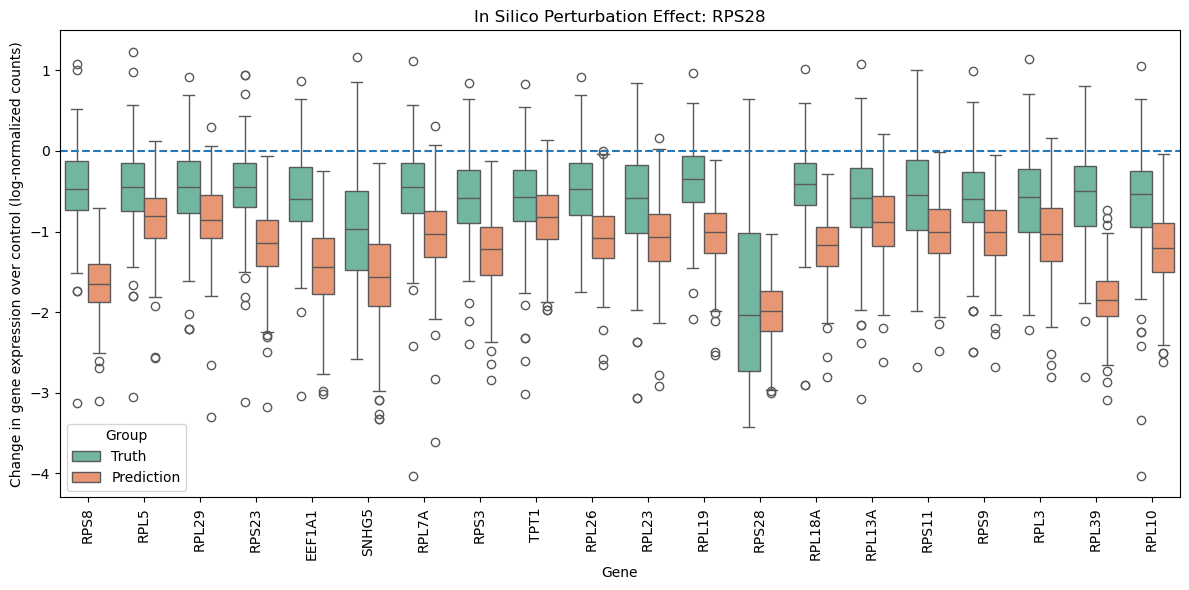

In [177]:
base = get_true_adata(['HNRNPC', 'non-targeting'], adata_train)
base = DEG_analysis(base)
top_genes = base.uns['rank_genes_groups']['names']['non-targeting'][:20]
print(top_genes)

controll_train = get_true_adata(['non-targeting'], adata_train)
controll_train = controll_train[:, controll_train.var_names.isin(top_genes)].copy()
control_test = contro_samp_data.copy()
control_test = control_test[:, control_test.var_names.isin(top_genes)].copy()
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['HNRNPC'], adata_train)

RPS28_new = RPS28_new[:, RPS28_new.var_names.isin(top_genes)].copy()
RPS28_true = RPS28_true[:, RPS28_true.var_names.isin(top_genes)].copy()

control_train_means = np.mean(controll_train.X, axis=0)
control_test_means = np.mean(control_test.X, axis=0)
assert len(control_train_means) == RPS28_true.shape[1], "基因数量不匹配"

RPS28_true_log = np.log(RPS28_true.X / control_train_means)

assert len(control_test_means) == RPS28_new.shape[1], "基因数量不匹配"

RPS28_new_log = np.log(RPS28_new.X / control_test_means)
DEG_names = RPS28_true.var['gene_name']
# 将每组数据转换为 pandas DataFrame 以便于绘图
true_df = pd.DataFrame(RPS28_true_log, columns=DEG_names)
new_df = pd.DataFrame(RPS28_new_log, columns=DEG_names)

# 添加额外的一列用于区分两组数据
true_df['Group'] = 'Truth'
new_df['Group'] = 'Prediction'

# 将两组数据合并在一起，用于绘制箱线图
combined_df = pd.concat([true_df, new_df])

# 将数据从宽格式转换为长格式，便于绘图
melted_df = pd.melt(combined_df, id_vars='Group', var_name='Gene', value_name='Expression')

# 创建箱线图，使用 seaborn 的 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='Expression', hue='Group', data=melted_df, palette='Set2')

# 调整图表的旋转角度以便于查看基因标签
plt.xticks(rotation=90)
plt.axhline(0, color='#2878B5', linestyle='--')
# 添加标题和轴标签
plt.title('In Silico Perturbation Effect: RPS28')

plt.ylabel('Change in gene expression over control (log-normalized counts)')

# 显示图表
plt.tight_layout()
plt.savefig('HNRNPC_effect.pdf')
plt.show()

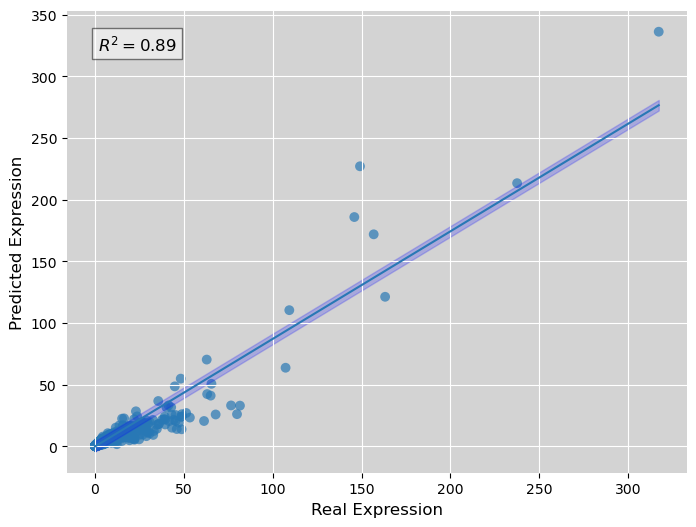

In [73]:
prediction = DGD(control_rep.z.detach())* lib_list  
obs = contro_samp_data.obs.copy()
var = contro_samp_data.var.copy()
RPS28_new = ad.AnnData(X=prediction.detach().cpu().numpy(), obs=obs, var=var)
RPS28_new.obs["gene"] = 'prediction'

RPS28_true = get_true_adata(['RPS28'], adata_train)
mean_true = np.mean(RPS28_true.X, axis=0)
mean_new = np.mean(RPS28_new.X, axis=0)

corr, p_value = pearsonr(mean_true, mean_new)
r_squared = corr ** 2  # 计算 R^2

# 线性回归拟合
slope, intercept = np.polyfit(mean_true, mean_new, 1)

# 使用 mean_true 的最小值和最大值来创建 x 值范围
x_vals = np.linspace(mean_true.min(), mean_true.max(), 100)
y_vals = slope * x_vals + intercept

# 计算回归线的标准误差，展示置信区间（波动范围）
y_fit = slope * mean_true + intercept
residuals = mean_new - y_fit
std_err = np.std(residuals)
confidence_interval = 1.96 * std_err

# 绘制散点图和置信区间
plt.figure(figsize=(8, 6))
plt.scatter(mean_true, mean_new, alpha=0.7, color='#2878B5', edgecolors='none', s=50)  # 取消黑边

# 绘制回归直线，颜色与散点一致
plt.plot(x_vals, y_vals, color='#2878B5')

# 绘制置信区间（波动范围）
plt.fill_between(x_vals, y_vals - confidence_interval, y_vals + confidence_interval, 
                 color='b', alpha=0.2, label='95% Confidence Interval')

# 添加标题和标签
plt.xlabel('Real Expression', fontsize=12)
plt.ylabel('Predicted Expression', fontsize=12)

# 设置背景颜色为淡灰色，网格线为白色
plt.gca().set_facecolor('#d3d3d3')  # 背景淡灰色
plt.grid(True, color='white')  # 网格线白色

# 取消坐标框的黑边
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 取消上边框
ax.spines['right'].set_visible(False)  # 取消右边框
ax.spines['left'].set_visible(False)   # 取消左边框
ax.spines['bottom'].set_visible(False)  # 取消下边框

# 在图片中显示 R^2
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 显示图形
plt.savefig("RPS28_mean_expression.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [256]:
# get logfc
# move location of new control data out of loop
perturb_gene_list = adata_train.obs['gene'].unique().tolist()
perturb_gene_list.remove('non-targeting')

control_rep, control_rep_optimizer, lib_list = locate_new_control(contro_samp_data, DGD, gene_name)
deg_mode = False
prc_mode = True
logfc_list = []
for gene in perturb_gene_list:
    control_rep_copy = RepresentationLayer(nrep=latent_dim,nsample=200,values=control_rep.z.detach().clone())
    control_rep_optimizer_copy = torch.optim.Adam(control_rep_copy.parameters(), lr=1e-3, weight_decay=1e-4, betas=[0.5,0.7])

    test_gene = gene
    pert_list = [test_gene,'non-targeting']
    pca, plot_data, projected = plot(gmm, rep, labels, pert_list, n_components=2)
    _, logfc = insilico_perturb(test_gene, control_rep, control_rep_optimizer, lib_list, DGD, contro_samp_data, pca, plot_data, projected, degs = deg_mode, prc = prc_mode)
    logfc_list.append(logfc)

Gene: BUB1 is in the transcriptome, index: 1192
BUB1 final Pearson correlation: 0.3375154115733375 prc increase: 198.68%
Gene: UBL5 is in the transcriptome, index: 7295
UBL5 final Pearson correlation: 0.3362040752811643 prc increase: 37.98%
Gene: C9orf16 is in the transcriptome, index: 4027
C9orf16 final Pearson correlation: -0.0328670019526964 prc increase: 76.96%
Gene: TIMM9 is in the transcriptome, index: 5700
TIMM9 final Pearson correlation: 0.10791300738472229 prc increase: 15.83%
Gene: RPL3 is in the transcriptome, index: 8220
RPL3 final Pearson correlation: 0.2237578326472497 prc increase: 5.87%
Gene: PSTK is in the transcriptome, index: 4418
PSTK final Pearson correlation: 0.057469170848738725 prc increase: -4.22%
Gene: MED1 is in the transcriptome, index: 6733
MED1 final Pearson correlation: 0.39730986393201007 prc increase: 33.06%
Gene: RPL10A is in the transcriptome, index: 2840
RPL10A final Pearson correlation: 0.2426038997287364 prc increase: 67.73%
Gene: LIN54 is in the t

In [259]:
logfc_list_array = np.array(logfc_list)

In [265]:
len(logfc_list_array)

380

In [268]:
logfc_list_array

array([[ 0.11300131,  0.29144195,  0.39372813, ...,  0.3598891 ,
         0.34792867,  0.33751541],
       [ 0.24365766,  0.25369167,  0.26361011, ...,  0.31605592,
         0.32652542,  0.33620408],
       [-0.14263546, -0.12905741, -0.11634807, ..., -0.05195549,
        -0.04154228, -0.032867  ],
       ...,
       [ 0.07613353,  0.08040635,  0.08423003, ...,  0.10091335,
         0.10225678,  0.10336613],
       [ 0.58574975,  0.59165028,  0.59645467, ...,  0.62046242,
         0.62322809,  0.62474119],
       [ 0.36891012,  0.36821981,  0.36708927, ...,  0.35510208,
         0.35300366,  0.35157298]])

In [274]:
with open('logfc_result_and_result_list.txt', 'w') as f:
    for gene, result in zip(perturb_gene_list, logfc_list):
        f.write(f'Gene: {gene}, Result: {result}\n')

In [275]:
np.min(growth_rate)

-6.582999894574348

In [260]:
average_prc = np.mean(logfc_list_array, axis=1)
len(average_prc)

380

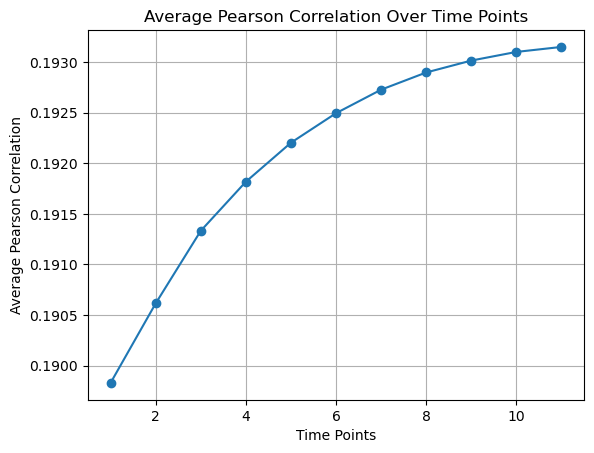

In [261]:
average_prc = np.mean(logfc_list_array, axis=0)
time_points = range(1, 12)  # 假设时间点为 1 到 11
plt.plot(time_points, average_prc, marker='o')
plt.title('Average Pearson Correlation Over Time Points')
plt.xlabel('Time Points')
plt.ylabel('Average Pearson Correlation')
plt.grid()
plt.show()

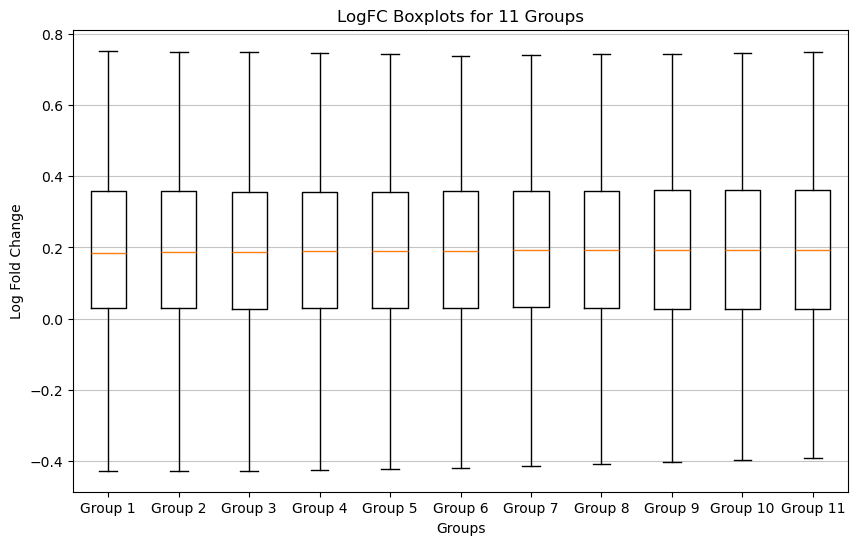

In [262]:
logfc_list_array = np.array(logfc_list)
plt.figure(figsize=(10, 6))
plt.boxplot(logfc_list_array, labels=[f'Group {i+1}' for i in range(logfc_list_array.shape[1])])

# 添加标签
plt.xlabel('Groups')
plt.ylabel('Log Fold Change')
plt.title('LogFC Boxplots for 11 Groups')

# 显示图像
plt.grid(axis='y', alpha=0.75)
plt.show()

In [210]:
increase_mask = first_values > 0
num_increased_groups = np.sum(increase_mask)
num_increased_groups


306

In [263]:

# 计算每组的第一个值和最后一个值
first_values = logfc_list_array[:, 0]
last_values = logfc_list_array[:, -1]


# 计算这些组的百分比增幅
percentage_increase = (last_values- first_values) / np.abs(first_values) * 100

for i, increase in enumerate(percentage_increase):
    print(f"Group {i+1}: {increase:.2f}%")

num_increased_groups = np.sum(percentage_increase>0)
num_increased_groups


Group 1: 198.68%
Group 2: 37.98%
Group 3: 76.96%
Group 4: 15.83%
Group 5: 5.87%
Group 6: -4.22%
Group 7: 33.06%
Group 8: 67.73%
Group 9: -23.60%
Group 10: 11.66%
Group 11: -5.62%
Group 12: 21.27%
Group 13: -24.03%
Group 14: 12.22%
Group 15: 0.83%
Group 16: -7.55%
Group 17: 13.19%
Group 18: 10.60%
Group 19: -13.99%
Group 20: 3.69%
Group 21: 55.98%
Group 22: 55.88%
Group 23: -11.03%
Group 24: 139.00%
Group 25: 16.02%
Group 26: 605.26%
Group 27: -14.07%
Group 28: 10.19%
Group 29: -20.05%
Group 30: 2.17%
Group 31: -3.99%
Group 32: 2.29%
Group 33: 0.91%
Group 34: 17.50%
Group 35: 3.78%
Group 36: -24.20%
Group 37: -2.04%
Group 38: 9.79%
Group 39: 3.93%
Group 40: 4.78%
Group 41: -28.81%
Group 42: 29.56%
Group 43: -17.93%
Group 44: -12.82%
Group 45: -7.30%
Group 46: -0.89%
Group 47: -28.66%
Group 48: 16.38%
Group 49: 51.69%
Group 50: -32.67%
Group 51: -1.60%
Group 52: 6.94%
Group 53: 242.33%
Group 54: 18.45%
Group 55: 13.50%
Group 56: -19.93%
Group 57: -3.42%
Group 58: 10.99%
Group 59: 13.92%


208

In [217]:

# 计算每组的第一个值和最后一个值
first_values = logfc_list_array[:, 0]
last_values = logfc_list_array[:, -1]

# 统计有多少组最后值大于第一个值
increase_mask = last_values > first_values
num_increased_groups = np.sum(increase_mask)

# 计算这些组的百分比增幅
percentage_increase = np.abs((last_values[increase_mask] - first_values[increase_mask]) / first_values[increase_mask]) * 100

# 输出结果
print(f"Number of groups where the last value is greater than the first: {num_increased_groups}")

for i, increase in enumerate(percentage_increase):
    print(f"Group {i+1}: {increase:.2f}%")

Number of groups where the last value is greater than the first: 185
Group 1: 7.02%
Group 2: 2.27%
Group 3: 183.51%
Group 4: 11.88%
Group 5: 2.63%
Group 6: 39.94%
Group 7: 42.04%
Group 8: 30.40%
Group 9: 4.12%
Group 10: 77.59%
Group 11: 20.06%
Group 12: 117.28%
Group 13: 46.18%
Group 14: 2.21%
Group 15: 9.91%
Group 16: 300.30%
Group 17: 8.46%
Group 18: 54.35%
Group 19: 24.81%
Group 20: 46.96%
Group 21: 2.62%
Group 22: 4.98%
Group 23: 0.61%
Group 24: 28.15%
Group 25: 30.93%
Group 26: 60.31%
Group 27: 6.48%
Group 28: 6.02%
Group 29: 14.60%
Group 30: 14.21%
Group 31: 7.95%
Group 32: 12.29%
Group 33: 54.02%
Group 34: 27.21%
Group 35: 31.02%
Group 36: 4.86%
Group 37: 6.69%
Group 38: 77.38%
Group 39: 26.80%
Group 40: 13.70%
Group 41: 11.08%
Group 42: 91.62%
Group 43: 73.67%
Group 44: 68.94%
Group 45: 13.82%
Group 46: 25.83%
Group 47: 47.91%
Group 48: 22.19%
Group 49: 21.69%
Group 50: 3.05%
Group 51: 18.26%
Group 52: 1.73%
Group 53: 5.06%
Group 54: 4.46%
Group 55: 11.72%
Group 56: 1.40%
Group

In [96]:
gene_name = []
results = []
with open('perturb_and_result_list.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # 解析每一行，提取基因名和结果
        gene_part, result_part = line.split(', Result: ')
        gene = gene_part.split(': ')[1]  # 获取基因名
        result_str = result_part.strip()  # 去掉空白字符

        # 处理结果，将字符串转换为列表
        result = eval(result_str)  # 使用 eval 将字符串转换为列表

        # 将数据添加到对应的列表
        gene_name.append(gene)
        results.append(result)

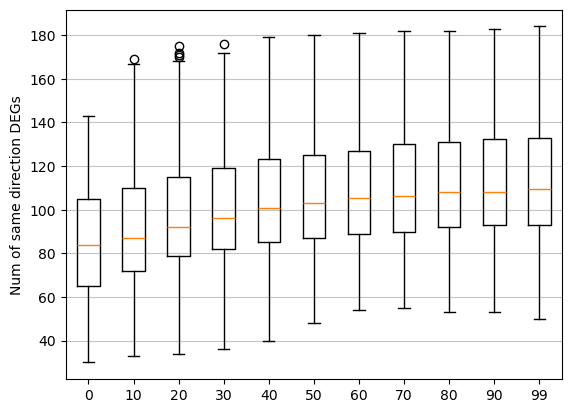

In [91]:
epochs = [0, 10,20,30,40,50,60,70,80,90,99]
epoch_values = [[results[i][epoch] for i in range(len(results))] for epoch in epochs]

# 生成箱线图
plt.boxplot(epoch_values, labels=[f'{epoch}' for epoch in epochs])
plt.ylabel('Num of same direction DEGs')
plt.grid(axis='y', alpha=0.75)
plt.savefig('same_direction_boxplot.pdf', format='pdf', bbox_inches='tight')

In [108]:
max_values = np.max(results, axis=1)
sorted_indices = np.argsort(max_values)[-5:]  # 获取最大5个元素的索引
sorted_indices = sorted_indices[np.argsort(max_values[sorted_indices])]  # 确保索引按顺序排列

# 获取最大5个元素及其索引
max_elements = max_values[sorted_indices]

# 打印结果
for index, value in zip(sorted_indices, max_elements):
    print(f'Index: {index}, Max Value: {value}')
print(gene_name[321])

Index: 76, Max Value: 176
Index: 73, Max Value: 179
Index: 98, Max Value: 180
Index: 321, Max Value: 180
Index: 133, Max Value: 184
RPS9


In [188]:
perturb_gene_list = adata_train.obs['gene'].unique().tolist()
perturb_gene_list.remove('non-targeting')

result_list = []
for gene in perturb_gene_list:
    
    control_rep, control_rep_optimizer, lib_list, pca, plot_data, projected = locate_new_control(contro_samp_data, DGD, gene)
    same_deg_list = insilico_perturb(gene, control_rep, control_rep_optimizer, lib_list, DGD, contro_samp_data, pca, plot_data, projected)
    result_list.append(same_deg_list)
    print('Gene',gene,'has average same direction num:',sum(same_deg_list)/len(same_deg_list))
    

Gene: BUB1 is in the transcriptome, index: 1192
Gene BUB1 has average same direction num: 107.1
Gene: UBL5 is in the transcriptome, index: 7295
Gene UBL5 has average same direction num: 69.4
Gene: C9orf16 is in the transcriptome, index: 4027
Gene C9orf16 has average same direction num: 72.11
Gene: TIMM9 is in the transcriptome, index: 5700
Gene TIMM9 has average same direction num: 88.47
Gene: RPL3 is in the transcriptome, index: 8220
Gene RPL3 has average same direction num: 89.11
Gene: PSTK is in the transcriptome, index: 4418
Gene PSTK has average same direction num: 90.95
Gene: MED1 is in the transcriptome, index: 6733
Gene MED1 has average same direction num: 81.46
Gene: RPL10A is in the transcriptome, index: 2840
Gene RPL10A has average same direction num: 148.48
Gene: LIN54 is in the transcriptome, index: 2107
Gene LIN54 has average same direction num: 103.01
Gene: NUP98 is in the transcriptome, index: 4478
Gene NUP98 has average same direction num: 116.47
Gene: ANAPC15 is in th

In [189]:
with open('perturb_and_result_list.txt', 'w') as f:
    for gene, result in zip(perturb_gene_list, result_list):
        f.write(f'Gene: {gene}, Result: {result}\n')

In [192]:
result_array = np.array(result_list)

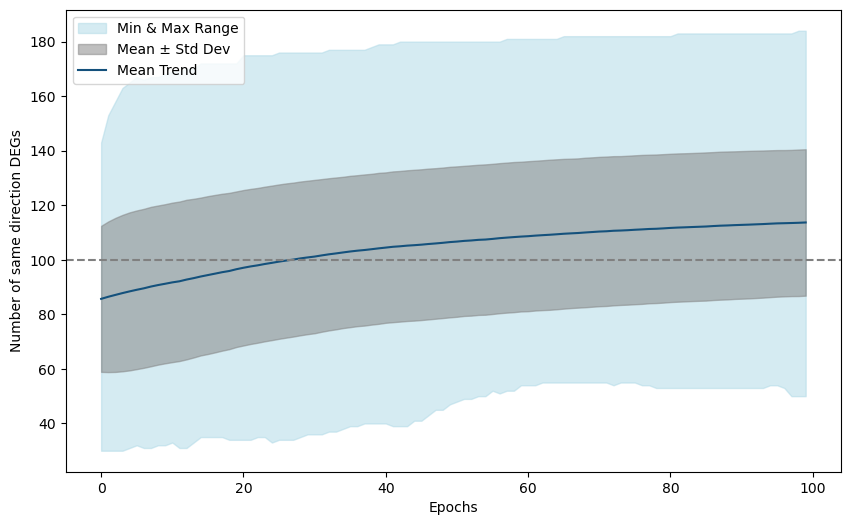

In [260]:
mean_values = np.mean(result_array, axis=0)
min_values = np.min(result_array, axis=0)
max_values = np.max(result_array, axis=0)
std_values = np.std(result_array, axis=0)

# X轴的索引
x = np.arange(100)

# 绘制图形
plt.figure(figsize=(10, 6))

# 绘制区域图：最大值和最小值
plt.fill_between(x, min_values, max_values, color='lightblue', alpha=0.5, label='Min & Max Range')
plt.fill_between(x, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.5, label='Mean ± Std Dev')
# 绘制均值趋势线
plt.plot(x, mean_values, label='Mean Trend', color='#14517C')
plt.axhline(y=100, color='grey', linestyle='--')
# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Number of same direction DEGs')
# 显示图例
plt.legend( loc='upper left')
plt.savefig('mean_std_same_direction_trend.pdf')
# 展示图表


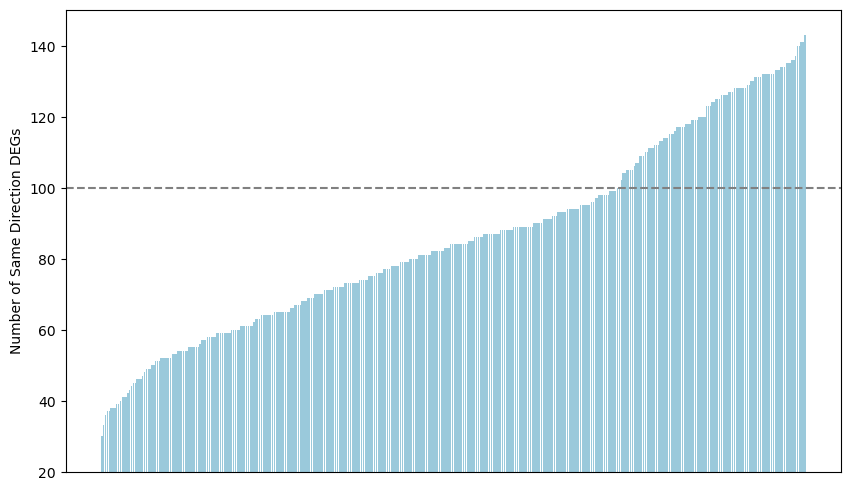

In [ ]:
# Sort the epoch0_deg array
sorted_epoch0_deg = np.sort(epoch0_deg)
# change
# Bar plot for sorted epoch 0
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_epoch0_deg)), sorted_epoch0_deg, color = '#9AC9DB')
plt.axhline(y=100, color='grey', linestyle='--')
plt.ylabel('Number of Same Direction DEGs')
plt.ylim(20, None)
plt.xticks([])
plt.savefig('epoch0_deg.pdf', format='pdf')
plt.show()


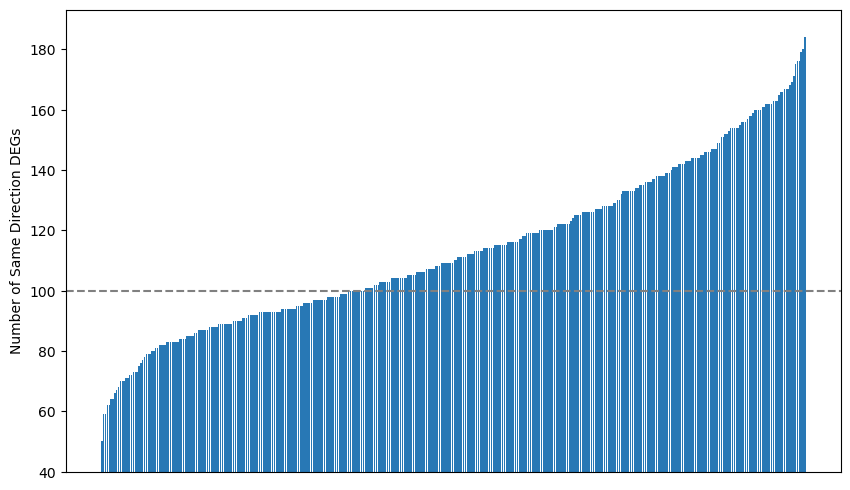

In [236]:
epoch100_deg = result_array[:,99]
# Sort the epoch0_deg array
sorted_epoch100_deg = np.sort(epoch100_deg)

# Bar plot for sorted epoch 0
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_epoch100_deg)), sorted_epoch100_deg, color='#2878B5')
plt.axhline(y=100, color='grey', linestyle='--')
plt.ylabel('Number of Same Direction DEGs')
plt.ylim(40, None)
plt.xticks([])
plt.savefig('epoch100_deg.pdf', format='pdf')
plt.show()


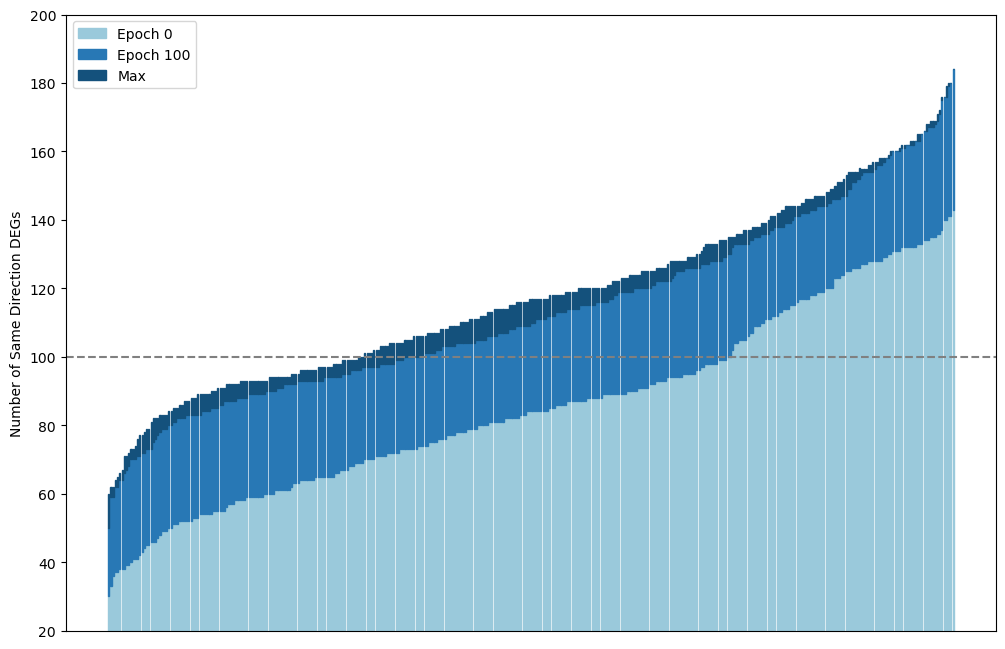

In [241]:
max_elements = np.max(result_array, axis=1)
epoch0_deg = result_array[:, 0]
epoch100_deg = result_array[:, 99]

# 对数据进行排序，便于更好的可视化
sorted_max_elements = np.sort(max_elements)
sorted_epoch0_deg = np.sort(epoch0_deg)
sorted_epoch100_deg = np.sort(epoch100_deg)

# 创建柱状图
plt.figure(figsize=(12, 8))
bar_width = 0.5  # 定义柱的宽度

# 创建X轴的索引
x = np.arange(len(sorted_max_elements))

# 绘制堆叠柱状图
plt.bar(x, sorted_epoch0_deg, bar_width, color='#9AC9DB', edgecolor= '#9AC9DB', label='Epoch 0')
plt.bar(x, sorted_epoch100_deg - sorted_epoch0_deg, bar_width, bottom=sorted_epoch0_deg, color='#2878B5', edgecolor= '#2878B5',label='Epoch 100')
plt.bar(x, sorted_max_elements - sorted_epoch100_deg, bar_width, bottom=sorted_epoch100_deg, color='#14517C', edgecolor='#14517C',label='Max')

plt.ylabel('Number of Same Direction DEGs')
plt.axhline(y=100, color='grey', linestyle='--')
plt.ylim(20, 200)
plt.xticks([])

# 添加图例
plt.legend()

plt.savefig('0_100_max_same_deg.pdf', format='pdf')